In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Configs
# path to directory to dump embeddings
run_id = 'run_1'
#maxID : number of products to process starting: 1001
max_id = 1999

In [3]:
def toFilter(path, maxNumber= 1999):
    try:
        number = path.split('_')[0]
        return int(number) <= maxNumber
    except:
        return False

In [4]:
embeddings = {}
video_frame_map = {}
sift = cv2.SIFT_create()
def load_embeddings():
    path_to_videos = "./SegmentedData/InputImages"
    videoDirs = os.listdir(path_to_videos)
    # videos = videos[:2]
    print(videoDirs)
    count = 0
    for videoDir in videoDirs:
        if(not toFilter(videoDir, max_id)):
            continue
        print("--------------------- Processing video: ", count, videoDir)
        count += 1
        imageFileNames = os.listdir(os.path.join(path_to_videos, videoDir))
        for imageFileName in imageFileNames:
            print("Processing image: ", imageFileName)
            image_path = os.path.join(path_to_videos, videoDir, imageFileName)
            img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            keypoints, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                embeddings[imageFileName] = descriptors
                video_frame_map[imageFileName] = img
load_embeddings()

['1056', '1016', '1026', '1012', '1019', '1025', '1037', '1035', '1004', '1009', '1021', '1051', '1067', '1065', '1042', '1071', '1057', '1070', '1003', '1074', '1058', '1005', '1050', '1046', '1007', '1008', '1032', '1020', '1077', '1036', '1022', '1048', '1055', '1062', '1049', '1023', '1034', '1081', '1045', '1029', '1075', '1054', '1082', '1066', '1064', '1002', '1017', '1024', '1018', '1080', '1011', '1060', '1039', '1030', '1078', '1013', '1040', '1061', '1063', '1028', '1015', '1033', '1041', '1038', '1014', '1079', '1043', '1068', '1083', '1076', '1069', '1073', '1010', '1001', '1031', '1044', '1027', '1052', '1072', '1006', '1053', '1047', '1059']
--------------------- Processing video:  0 1056
Processing image:  1056_16.png
Processing image:  1056_18.png
Processing image:  1056_7.png
Processing image:  1056_13.png
Processing image:  1056_15.png
Processing image:  1056_12.png
Processing image:  1056_10.png
Processing image:  1056_0.png
Processing image:  1056_2.png
Processing 

In [5]:
torch.save(embeddings, os.path.join(run_id, "siftDescriptors.pt"))

In [6]:
products = {}
def load_products():
    # Read the CSV file
    df = pd.read_csv('output.csv')

    # Create the dictionary
    for _, row in df.iterrows():
        product_id = str(row['id'])
        products[product_id] = {
            'id': product_id,
            'nickname': row['nickname'],
            'price': row['price']
        }
load_products()

In [7]:
images = {}
image_map = {}
image_cropped_map = {}
def load_images():
    path_to_images = "./SegmentedData/OutputImages"
    imageDirs = os.listdir(path_to_images)
    print(imageDirs)
    imageDirCount = 0
    for imageDir in imageDirs:
        try:
            if(not toFilter(imageDir, max_id)):
                continue
            print("Processing imageDir: ", imageDirCount)
            imagePaths = os.listdir(os.path.join(path_to_images, imageDir))
            count = 0
            print("Processing imageDir: ", imageDir)
            for imagePath in imagePaths:
                image = cv2.cvtColor(cv2.imread(os.path.join(path_to_images, imageDir, imagePath)), cv2.COLOR_BGR2RGB)
                # image = Image.open(os.path.join(path_to_images, imageDir, imagePath))
                if image is None:
                    continue

                # Detect SIFT keypoints and descriptors
                keypoints, descriptors = sift.detectAndCompute(image, None)
                if descriptors is not None:
                    images[imageDir + "_" + str(count)] = descriptors
                    image_map[imageDir + "_" + str(count) ] = image

                count += 1
        except:
            print("Error processing imageDir: ", imageDir)
        imageDirCount += 1
        
load_images()

['1056', '1016', '1026', '1012', '1019', '1025', '1037', '1035', '1009', '1021', '1067', '1065', '1042', '1071', '1057', '1070', '1003', '1074', '1058', '1005', '1050', '1046', '1007', '1008', '1032', '1020', '1077', '1036', '1022', '1048', '1055', '1062', '1049', '1023', '1034', '1081', '1045', '1029', '1075', '1054', '1082', '1066', '1064', '1002', '1017', '1024', '1018', '1080', '1011', '1060', '1039', '1030', '1078', '1013', '1040', '1061', '1063', '1028', '1033', '1041', '1038', '1079', '1043', '1068', '1083', '1076', '1069', '1073', '1010', '1001', '1031', '1044', '1027', '1052', '1072', '1006', '1053', '1047', '1059']
Processing imageDir:  0
Processing imageDir:  1056
Processing imageDir:  1
Processing imageDir:  1016
Processing imageDir:  2
Processing imageDir:  1026
Processing imageDir:  3
Processing imageDir:  1012
Processing imageDir:  4
Processing imageDir:  1019
Processing imageDir:  5
Processing imageDir:  1025
Processing imageDir:  6
Processing imageDir:  1037
Processing

In [8]:
bf = cv2.BFMatcher()
def searchProduct(imageFeatures):
    # Process the input image
    query_descriptors = imageFeatures.astype(np.float32)


    # Calculate cosine similarities
    similarities = []
    for id, embedding in embeddings.items():
        descriptors = embedding.astype(np.float32)
        matches = bf.knnMatch(query_descriptors, descriptors, k=2)
        good = []
        ratio = 0.75  # Adjust this value as needed
        for m, n in matches:
            if m.distance < ratio * n.distance:
                good.append([m])
        # similarity = cosine_similarity(query_embedding, embedding)
        similarities.append((id, len(good)))

    top_five = sorted(similarities, key=lambda item: item[1], reverse=True)[:5]
    # filtered_results = [(id, sim) for id, sim in top_five if sim > 0.8]
    # Get the product details for the top five items
    filtered_products = []
    for closest_id, maxSimilarity in top_five:
        # closest_id = closest_id.split("_")[0]
        product_details = products[closest_id.split("_")[0]]
        filtered_products.append((product_details, closest_id, maxSimilarity))

    return filtered_products

In [9]:
match = 0
for id, feature in images.items():
    product_id = id.split("_")[0]
    query_product = products[product_id]
    results = searchProduct(feature)
    print("Query: ", query_product, results)
    
    if query_product['id'] == results[0][0]['id']:
    # or query_product['id'] == results[1][0]['id'] or query_product['id'] == results[2][0]['id'] or query_product['id'] == results[3][0]['id'] or query_product['id'] == results[4][0]['id']:
        match += 1
    
    print(query_product['nickname'], "-------", results[0][0]['nickname'])
print("Match: ", match, "Total: ", len(images))

Query:  {'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10} [({'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10}, '1056_6.png', 968), ({'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10}, '1056_7.png', 947), ({'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10}, '1056_9.png', 602), ({'id': '1025', 'nickname': 'Lux Soap', 'price': 10}, '1025_23.png', 392), ({'id': '1047', 'nickname': 'Yippee Noodles', 'price': 14}, '1047_8.png', 390)]
Yippee Noodles ------- Yippee Noodles
Query:  {'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10} [({'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10}, '1056_0.png', 372), ({'id': '1008', 'nickname': 'Diamond Soap', 'price': 10}, '1008_43.png', 358), ({'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10}, '1056_17.png', 334), ({'id': '1025', 'nickname': 'Lux Soap', 'price': 10}, '1025_11.png', 326), ({'id': '1056', 'nickname': 'Yippee Noodles', 'price': 10}, '1056_18.png', 321)]
Yippee Noodles ------- Yippee Noodles

KeyboardInterrupt: 

Query:  {'id': '1002', 'nickname': 'Cinthol Soap', 'price': 10} [({'id': '1002', 'nickname': 'Cinthol Soap', 'price': 10}, '1002_48.png', 113), ({'id': '1002', 'nickname': 'Cinthol Soap', 'price': 10}, '1002_8.png', 111), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_21.png', 108), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_6.png', 89), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_37.png', 88)]


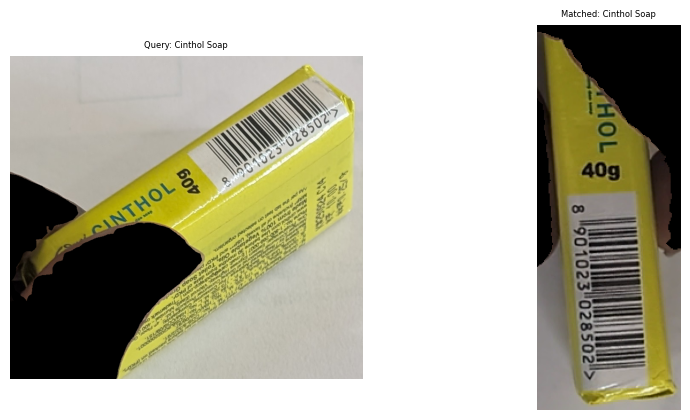

Cinthol Soap ------- Cinthol Soap
Query:  {'id': '1002', 'nickname': 'Cinthol Soap', 'price': 10} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_7.png', 99), ({'id': '1002', 'nickname': 'Cinthol Soap', 'price': 10}, '1002_48.png', 78), ({'id': '1002', 'nickname': 'Cinthol Soap', 'price': 10}, '1002_28.png', 72), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_37.png', 63), ({'id': '1002', 'nickname': 'Cinthol Soap', 'price': 10}, '1002_7.png', 59)]


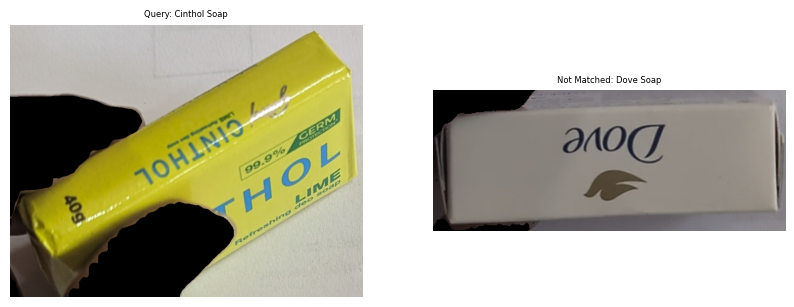

Cinthol Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3.png', 177), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_4.png', 173), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_0.png', 142), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2.png', 140), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_1.png', 137)]


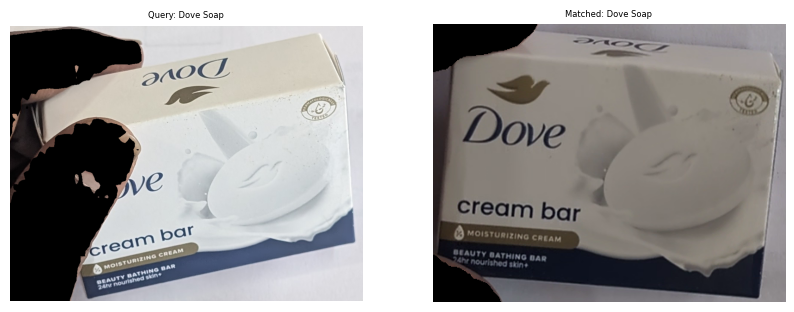

Dove Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_0.png', 158), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_1.png', 154), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_2.png', 148), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_3.png', 142), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_7.png', 92)]


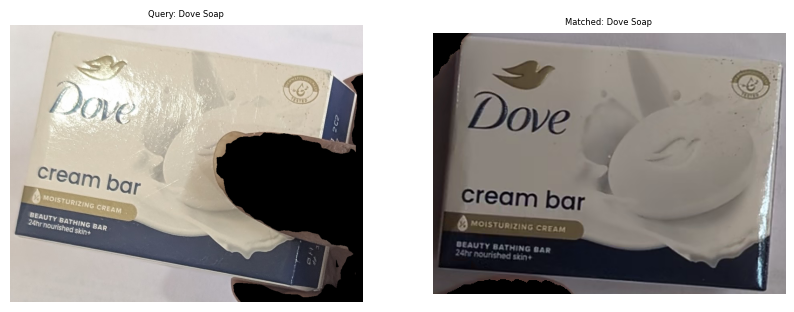

Dove Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_28.png', 146), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_37.png', 130), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_38.png', 128), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_30.png', 121), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_7.png', 120)]


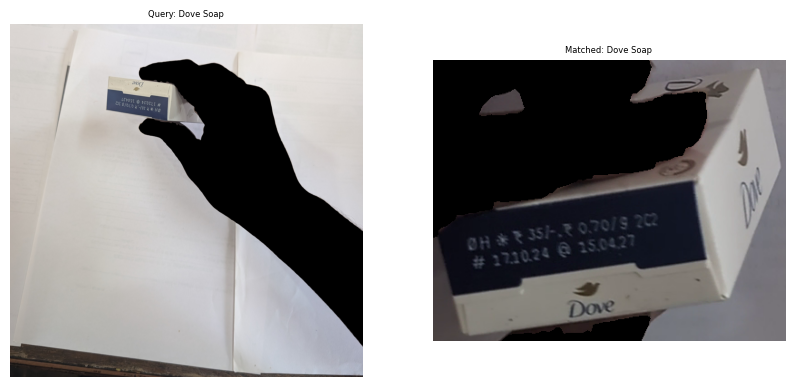

Dove Soap ------- Dove Soap
Query:  {'id': '1001', 'nickname': 'Dove Soap', 'price': 35} [({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_14.png', 816), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_13.png', 772), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_10.png', 756), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_12.png', 754), ({'id': '1001', 'nickname': 'Dove Soap', 'price': 35}, '1001_9.png', 752)]


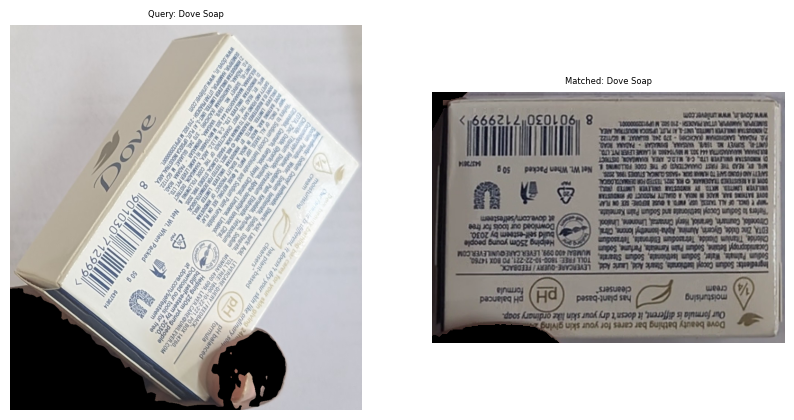

Dove Soap ------- Dove Soap
Match:  5 Total:  6


In [9]:

match = 0
for id, feature in images.items():
    product_id = id.split("_")[0]
    query_product = products[product_id]
    results = searchProduct(feature)
    print("Query: ", query_product, results)
    
    
        
    # Plot images in a 2x1 matrix
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the query image
    query_image = image_map[id]
    axes[0].imshow(query_image)
    axes[0].set_title(f"Query: {query_product['nickname']}", fontsize=6)
    axes[0].axis('off')

    # query_crop_image = image_cropped_map[id]
    # axes[1].imshow(query_crop_image)
    # axes[1].set_title(f"QueryCropped: {query_product['nickname']}", fontsize=6)
    # axes[1].axis('off')

    # Plot the matched video frame
    if product_id == results[0][0]['id']:
        matchString = "Matched"
    else:
        matchString = "Not Matched"
    matched_id = results[0][1]
    matched_frame = video_frame_map[matched_id]
    axes[1].imshow(matched_frame)
    axes[1].set_title(f"{matchString}: {results[0][0]['nickname']}", fontsize=6)
    axes[1].axis('off')

    # axes[3].imshow(video_frame_map_masked[matched_id])
    # axes[3].set_title(f"{matchString}: {results[0][0]['nickname']}", fontsize=6)
    # axes[3].axis('off')

    # axes[4].imshow(video_frame_map_cropped[matched_id])
    # axes[4].set_title(f"{matchString}: {results[0][0]['nickname']}", fontsize=6)
    # axes[4].axis('off')


    plt.show()
    if product_id == results[0][0]['id']:
        match += 1
    
    print(query_product['nickname'], "-------", results[0][0]['nickname'])
print("Match: ", match, "Total: ", len(images))